In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from config import *
from encoder import *
from data import *
from clip import *
from clip3d import *
from eval import *
from augmentor import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



Random seed set to 333
using device:  cpu


In [3]:
# ---- update configs ----
overwrite = True
model_name = 'test3d'
text_config['cl']['die7d'] = True # udpate text_config here if needed
model_name = model_name + "___" + "_".join(get_true_components(text_config))
txt_ls = ['will die', 'will survive']

update_config(
    model_name = model_name,
    ts_aug = True,
    balance = True,
    block_target = True,
    txt_ls = txt_ls,
    patience = 20,
    num_saves = 20,
    num_epochs = 1,
    text_config = text_config
)
config_dict = get_config_dict()
config_dict

{'device': 'cpu',
 'batch_size': 128,
 'text_encoder_name': 'sentence-transformers/all-mpnet-base-v2',
 'ts_encoder_name': 'hr_vae_linear_medium',
 'ts_aug': True,
 'ts_normalize': False,
 'ts_encode': False,
 'block_target': True,
 'balance': True,
 'model_name': 'test3d___die7d_ga_bwt_sumb_simple_succ_inc_histogram',
 'embedded_dim': 128,
 'init_lr': 0.0001,
 'patience': 20,
 'num_saves': 20,
 'num_epochs': 1,
 'loss_type': 'block_diagonal',
 'txt_ls': ['will die', 'will survive'],
 'text_config': {'cl': {'die7d': True, 'fio2': False},
  'demo': {'ga_bwt': True, 'gre': False, 'apgar_mage': False},
  'ts': {'sumb': True,
   'sumd': False,
   'simple': True,
   'full': False,
   'event1': False,
   'succ_inc': True,
   'histogram': True}}}

In [4]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   10.5s
[Parallel(n_jobs=9)]: Done 1901 tasks      | elapsed:   11.1s
[Parallel(n_jobs=9)]: Done 33453 tasks      | elapsed:   19.3s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   27.7s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.   Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 9454 tasks      | elapsed:    2.9s
[Parallel(n_jobs=9)]: Done 41454 tasks      | elapsed:   12.2s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:   17.3s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  It shows high variability.  Low amount of consecutive increases. 


In [5]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 500
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)



# ---- ready dataloaders ---- 
ts_f_train, tx_f_train_ls, labels_train = get_features3d(df_train,
                                                         config_dict['ts_encoder_name'], 
                                                         config_dict['text_encoder_name'], 
                                                         config_dict['ts_normalize'],
                                                         config_dict['ts_encode'])
train_dataloader = CLIP3DDataset(ts_f_train, tx_f_train_ls, labels_train).dataloader(batch_size=config_dict['batch_size'])
ts_f_test, tx_f_test_ls, labels_test = get_features3d(df_test, 
                                                      config_dict['ts_encoder_name'], 
                                                      config_dict['text_encoder_name'], 
                                                      config_dict['ts_normalize'],
                                                      config_dict['ts_encode'])
test_dataloader = CLIP3DDataset(ts_f_test, tx_f_test_ls, labels_test).dataloader(batch_size=config_dict['batch_size'])


# ---- ready eval inputs ----
# create a onehot indicator of true text of first level of outcome, "this infant will die in 7 days"
df_train['true1'] = df_train['cl_event'].apply(lambda x: 1 if x == txt_ls_org[0] else 0)
df_train['true2'] = df_train['cl_event'].apply(lambda x: 1 if x == txt_ls_org[1] else 0)
df_train['text1'] = config_dict['txt_ls'][0]
df_train['text2'] = config_dict['txt_ls'][1]
evalinputs_train = EvalInputs(df_train, 
                              config_dict['ts_encoder_name'],
                              config_dict['text_encoder_name'], 
                              config_dict['ts_normalize'], 
                              config_dict['ts_encode'],
                              clip_type="3d")

df_test['true1'] = df_test['cl_event'].apply(lambda x: 1 if x == txt_ls_org[0] else 0)
df_test['true2'] = df_test['cl_event'].apply(lambda x: 1 if x == txt_ls_org[1] else 0)
df_test['text1'] = config_dict['txt_ls'][0]
df_test['text2'] = config_dict['txt_ls'][1]
evalinputs_test = EvalInputs(df_test, 
                              config_dict['ts_encoder_name'],
                              config_dict['text_encoder_name'], 
                              config_dict['ts_normalize'], 
                              config_dict['ts_encode'],
                              clip_type="3d")


Original class distribution:
Class This infant will die in 7 days. : 384
Class This infant will survive. : 500

Target size per class: 287

Final class distribution:
Class This infant will die in 7 days. : 384
Class This infant will survive. : 500


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Main Usage

In [6]:
# ---- ready data storage ---- 
import shutil
if overwrite:
    # remove the subfolder './results/'+model_name
    if os.path.exists('./results/'+model_name):
        shutil.rmtree('./results/'+model_name)
    overwrite = False # reset overwrite to False

if not os.path.exists('./results/'+model_name):
    os.makedirs('./results/'+model_name)
model_path = './results/'+model_name+'/model.pth' 
eval_path = './results/'+model_name+'/evals.pth'
config_path = './results/'+model_name+'/config.pth'
if not os.path.exists(config_path):
    torch.save(config_dict, config_path)

# ---- ready model ----
# for the sake of dimension
ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.loc[:1,:], 
                                                   config_dict['ts_encoder_name'], 
                                                 config_dict['text_encoder_name'], 
                                                 config_dict['ts_normalize'],
                                                 config_dict['ts_encode'])
model = CLIP3DModel(
            ts_dim=ts_f_dim.shape[1],
            text_dim=tx_f_dim_ls[0].shape[1],
            n_text=len(tx_f_dim_ls),
            output_dim=config_dict['embedded_dim']
        )
optimizer = torch.optim.AdamW(model.parameters(), lr=config_dict['init_lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=config_dict['patience'],          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)
train_eval_metrics_list = []
test_eval_metrics_list = []
train_losses = []
test_losses = []

Layer (type:depth-idx)                                                 Param #
CLIP3DModel                                                            1
├─Sequential: 1-1                                                      --
│    └─Linear: 2-1                                                     38,528
│    └─BatchNorm1d: 2-2                                                256
│    └─LeakyReLU: 2-3                                                  --
│    └─Dropout: 2-4                                                    --
│    └─ResidualBlock: 2-5                                              --
│    │    └─Sequential: 3-1                                            66,688
│    │    └─LeakyReLU: 3-2                                             --
│    └─ResidualBlock: 2-6                                              --
│    │    └─Sequential: 3-3                                            66,688
│    │    └─LeakyReLU: 3-4                                             --
│    └─ResidualBlock:

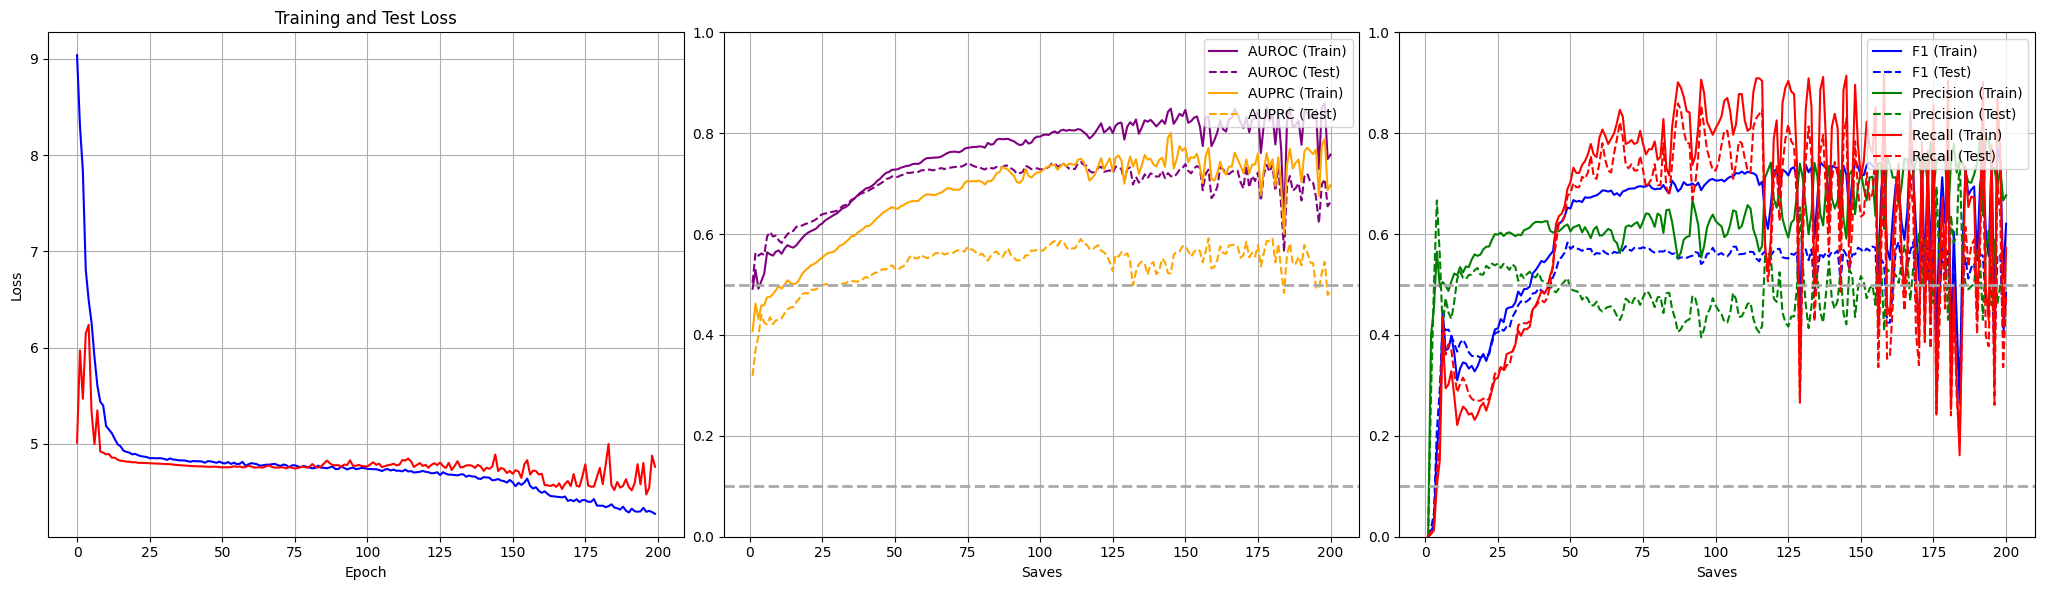

In [8]:
if overwrite or not os.path.exists(model_path):
    
    for i in range(200): 
        train_losses_tmp, test_losses_tmp = train_clip(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                config_dict['num_epochs'], 
                                                device,
                                                config_dict['loss_type'])
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        train_eval_metrics = eval_clip3d(model, evalinputs_train)
        test_eval_metrics = eval_clip3d(model, evalinputs_test)
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_path)
        # if i % 10 == 0: # every 10 saves, evaluate the model
        eval_dict = torch.load(eval_path)
        eval_dict_eng = eng_eval_metrics(eval_dict, binary=True)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)
    
else:
    model.load_state_dict(torch.load(model_path))
    eval_dict = torch.load(eval_path)
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=False)